# Missing Values Treatment in Data Science

In an application-orientated field like data science, available datasets are almost always incomplete. Whether you like it or not, missing values treatment will become part of your analysis. 

Even in the situation where a data scientist quickly drops incomplete records from a dataset, a missing values treatment has (unconsciously) been chosen. Is it the most appropriate method, though? And will the analysis outcome be different when another missing data method is applied? In this blogpost, we present an interactive plot to explore the effect of missing data and missing data methods on the outcome of a data science pipeline. 

## Missing data mechanisms

In missing data theory, we classify missing data problems into three categories: MCAR, MAR and MNAR missingness. Consider a dataset with outcome feature Y, predicting features X and some variable Z that is not used in the analysis. For any dataset with missing values in a certain feature X, the data is: 

- Missing Completely At Random (MCAR) when every cell has a fixed, equal probability of being missing. As a result, both large and small data values will be missing. 

- Missing At Random (MAR) when the probability of being missing depends on the observed values of another feature X or Z. For instance, records with large values on 'Coarse aggr.' have a higher probability of being missing on feature 'Fly ash'. The correlation between 'Coarge aggr.' and 'Fly ash' defines which values of 'Fly ash' become missing. 

- Missing Not At Random (MNAR) when the probability of being missing depends on the unobserved, missing data. This can either be because suitable covariates for explaining missingness have not been recorded or are otherwise unavailable or when the probability of being missing depends on the missing X values itself. Extending the previous example, if the probability of measuring 'Coarse aggr.' varied according to 'Coarse aggr.' itself, this is missing not at random. 

When the missingness depends on the outcome variable Y, and when outcome variable Y is complete observed, scientific researchers would consider this a MAR situation. After all, Y can be used in imputation model. However, in data science models, it is generally not accepted to use the outcome variable in the model. Therefore, if missingness in X depends on outcome variable Y, it makes more sense to call this a MNAR mechanism. 

The figures below schematically show how the multivariate relationship between any variable Z and a feature X is affected by completely random missingness, missingness depending on Z and missingness depending on X.

In [12]:
## add figures: Figures/MCAR.pdf, Figures/M(N)ARZ.pdf, Figures/M(N)ARX.pdf

## Missing data methods

There is an extensive amount of missing data methods available in several software packages. For our simulations, we use sklearn's data science pipeline. As such, it is easy to implement a method such as `dropna()` or to use the `mean` or `median` imputation functions from the `Imputer` class. 

But what are the effects of all these methods? In our simulations, we implemented the following six missing values treatments. 

- Listwise deletion: Drop incomplete rows from the dataset
- Mean imputation: imputation with the column (i.e. feature) mean
- Median imputation: imputation with the column (i.e. feature) median
- Random imputation: imputation with a randomly chosen observed value (per column)
- Regression imputation: each column (i.e. feature) is regressed on the other features. We predict each incomplete value by using the observed values of the other features. When a predictive value is unobserved, we mean impute first. 
- Stochastic regression imputation: regression imputation as explained above, but with the addition of some noise. To each imputation, we add (or subtract) a random value. We sample the noise from a normal distribution with mean 0 and standard deviation equal to the uncertainty of the regression imputation model. 

As sklearn has no other methods than mean, median and most frequent imputation, we made three custom adaptations of the `.Imputer` class for the random, regression and stochastic regression imputation methods. 

## Simulation setup

To get an idea of the effect of missing data methods on the outcome of a data science use case, we analyzed four datasets. We performed the simulations with two real datasets and four simulated datasets. The import and generation of these datasets can be found in our github repository, as well as all other simulation code. 

The setup is as follows: 

- We start by splitting a given dataset into 60% trainingset and 40% testset. 

- We then generate missing values in the training and testset with function `delete_data`. We assign missing values to all X features, but the output variable remains complete. In each simulation round, we create a MCAR, MARX, MARZ, MNARX and MNARZ missingness mechanism. In case of MARX, the missingness in feature X_1 depends on the values of feature X_2, X_2 depends on X_3 and so on. For MNARX, missingness in X_1 depends on X_1, X_2 on the values of X_2, and so on. For MARZ and MNARZ, we create a variable Z that correlates with the outcome variable Y. Next, the values of Z will determine which values in X become missing. For instance, records with a large value on Z have a higher probability to be missing on X_1. In case of MARZ, we use Z in the imputation model. In case of MNARZ, we do not use Z to impute. Note that Z is never part of the analysis model. 

- We create several missingness percentages. We generate the missingness such that 5%, 10%, 15%, up to 55% of the records have at least 1 missing value. In general, 50% of the cells of all incomplete rows have a missing value.

- Next, we apply the six missing data methods to each combination of missingness mechanism and missingness percentage. As said before, we apply `dropna()`, `mean` and `median` imputation with `.Imputer`, and `random`, `regression` and `stochastic` regression imputation with three custom functions. 

- The outcome variable Y is regressed on the X features with a `LinearRegression()` model from `sklearn.linear_model`. In particular, we apply a missing data method to the training set, fit the regression model on the training set, apply the same missing data method to the testset, and make the predictions with the fitted regression model. We evaluate our model by retrieving the following `sklearn.metrics`: `mean_squared_error`, sqrt(`mean_squared_error`), `mean_absolute_error` and `explained_variance`.

- Every combination of missingness mechanism, missingness proportion and missing values treatment is repeated 1000 times for the real datasets and 10 times for the simulated datasets (more is not needed due to the large size of these datasets). We report the average and IQR of the evaluation metrics. 

## Simulation outcome

The simulation outcomes show interesting results. All these results are presented in the interactive plot below. It is possible to inspect the outcomes by selecting the dataset, the missingness mechanism, the evaluation metric, the missing data method and whether you want to see the inter quartile range (IQR). A discussion of the output is given below the plot. 

In [13]:
# add interactive plot

### Concrete Slump Test

The Concrete Slump Test dataset has 7 numerical features that are used to predict the slump in cm (https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/). The error metrics for the original, complete dataset are as follows:

- MSE: 62.5
- RMSE: 7.8
- MAE: 6.5
- EV: 0.15

Compared with these values, missing values induce an increase of MSE, RMSE and MAE and a decrease of EV. This result is obvious, because the missing data creates uncertainty in the data. For the same reason, the evaluation error metrics become worse when the percentage of missingness increases. It is interesting to see this effect is largest for the drop.na method. 

When we inspect the results for a MCAR mechanism, we find that mean and median imputation perform better than regression, stochastic regression and random imputation. The results from mean and median imputation greatly overlap, indicating that the variable distributions in this dataset are quite symmetric. 

It is apparent that using regression imputation instead of mean/median imputation does not improve the model. This is the situation for all missingness mechanisms. Moreover, when the missingness depends on a variable outside the data (Z), it is not of influence whether or not you use Z to esimate the imputation (MARZ versus MNARZ). This outcome is quite unexpected. One possible explanation might be that in our simulation, the missingness in training set is comparable to the missingness in testset. You could argue that, as a consequence, any mistake you make fitting the imputation model, will result in the same mistakes in the testset. As a result, it could be that the accuracy of predictions are not affected. Of course, more research on this has to be done. 

Overall, if missingness depends on variable Z, the model performs slightly better than with the other missingness mechanisms. This has to do with the fact that Z correlates with outcome variable Y. Obviously, there are X features that have the same or an even larger correlation with outcome variable Y. As a result, you could expect that MARX and MNARX should give the same results as MARZ and MNARZ. However, in case of M(N)ARX, the missingness depends on all X features while in case of M(N)ARZ, the missingness depends on only one variable. Therefore, the effect of a Z-like X variable might not turn up in the M(N)ARX outcomes.

### Forest Fires

The Forest Fires data can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/. Estimating the area of a forest fire on the complete dataset does not give good results when using a linear regression model. The evaluation error metrics are as follows: 

- MSE: 4160.6
- RMSE: 50.39
- MAE: 21.5
- EV: -0.8

It is clear that a linear regression model is not useful to predict the area of forest fire. The explained variance even drops below 0! It is probably for that reason, that regression imputation gives results comparable to mean and median imputation. The imputation model is just as bad as the analysis model, and is not able to make reasonable estimations of the missing values. As a result, the regression model is nothing more than mean imputation. 

Stochastic regression imputation turns towards random imputation. Apparently, the uncertainty of the regression imputation model is so worse that adding noise to the imputations equals picking a random value from the observed data. In other words, the amount of noise added to the regression imputations is that large that the imputations come close to random imputations. 

Interestingly, we find that it is important whether or not you use Z to estimate the imputations (compare MARZ with MNARZ)! The improvement we expected to see with the 'Slump Concrete Test' dataset, we see now: regression imputation performs better than mean imputation when the information about the missingness is in this predicting variable (Z). 

However, I should remark that it is disturbing to see the extent to which the model improves by using regression imputation. The MSE, RMSE and MAE values become much smaller than the outcome of the complete dataset. Could this be an example of overfitting? 

### Simulated data

Our simulation datasets have either a poor or rich correlation structure (see figures below). A continuous output variable is sampled by making a linear equation with the features, using a random weights vector, and by adding noise. We generated the output variable with two levels of noise: little and much. 

FileNotFoundError: [Errno 2] No such file or directory: 'Figures/poor.png'

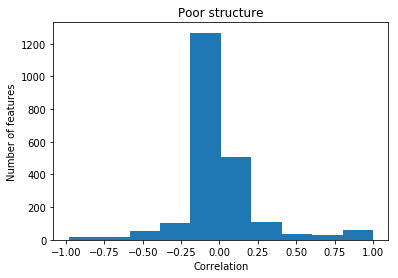

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df_poor = pd.read_table('Simulations/Data/custom_dataset_poor_little.txt', sep='\t')
fig = plt.figure()
plt.hist(df_poor.corr().values.ravel())
plt.xlabel('Correlation')
plt.ylabel('Number of features')
plt.title('Poor structure')
fig.savefig('Simulations/Figures/poor.png', bbox_inches='tight')

In [ ]:
df_rich = pd.read_table('Simulations/Data/custom_dataset_rich_little.txt', sep = '\t')
fig = plt.figure()
plt.hist(df_rich.corr().values.ravel())
plt.xlabel('Correlation')
plt.ylabel('Number of features')
plt.title('Rich structure')
fig.savefig('Simulations/Figures/rich.png', bbox_inches='tight')

The complete datasets are quite perfect (despite of the added noise). All four datasets have an explained variance perfecentage of 99.99%. The MSE and MAE are 0.01 and 0.08 for the datasets with little noise and 24.6 and 4.0 for the datasets with much noise.

The perfect characteristics of these datasets make that mean and median imputation exactly overlap. The same applies to regression and stochastic regression imputation. Furthermore, the drop.na method gives perfect results. The reason for this outcome is that, in particular, the rows with extreme values are removed from the dataset.

Nonetheless, what we understand from these simulation is that the performance of regression imputation is clearly affected by the correlation structure of the data. With strong correlations between the X features, regression and stochastic regression imputation perform better than mean and median imputation. At the same time, regression imputation performs well when there is much noise in the outcome variable. Although these results may seem contradictory, it makes sense that in case of noise in the outcome variable, regression imputation can add structure to the data. 

Note that more time has to be spend on investigating how the correlation structure is exactly related to the performance of the imputation models. In addition, Rianne is working on relating prediction accuracy to imputation accuracy. After all, do we choose our missing data methods based on convenience, based on evaluation error metrics or do we wish to restore the original data as best as possible? 

For now, mean and median imputation seem to be stable imputation methods for data science use cases. They are fast, easy to implement and very important, they are not sensitive for leakage. 

## Contact information

Rianne Schouten, Missing Data Specialist, rianne.schouten@dpa.nl, rianneschouten.github.io

Coen Seinen, Data Scientist, coen.seinen@bigdatarepublic.nl